# Modelling

In [1]:
# import required packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, learning_curve,validation_curve
from sklearn import tree
from sklearn.metrics import explained_variance_score, r2_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, IsolationForest,  RandomForestClassifier
import shap
import time
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

In [2]:
# load dataset obtained from Final_Merge.ipynb
heatwave = pd.read_csv('heatwave1.csv')
# delete redundant columns
heatwave = heatwave.iloc[: , 2:]
# rename column
heatwave = heatwave.rename(columns={'heat_wave_day': 'length'})
heatwave

country NUTS1 NUTS2      NUTS2_Label            lat_long        date  \
0         PT   PT1  PT16      Centro (PT)  ('39.25', '-9.25')  2018-08-02   
1         CH   CH0  CH03  Nordwestschweiz     ('47.5', '8.0')  2011-08-20   
2         CH   CH0  CH03  Nordwestschweiz     ('47.5', '8.0')  2015-07-01   
3         PT   PT1  PT11            Norte    ('41.5', '-7.0')  2018-08-02   
4         CH   CH0  CH03  Nordwestschweiz     ('47.5', '8.0')  2018-08-02   
...      ...   ...   ...              ...                 ...         ...   
3345      NO   NO0  NO02        Innlandet    ('61.75', '8.0')  2004-08-08   
3346      NO   NO0  NO02        Innlandet    ('61.75', '8.0')  2008-07-24   
3347      NO   NO0  NO02        Innlandet    ('61.75', '8.0')  2014-07-20   
3348      NO   NO0  NO02        Innlandet    ('61.75', '8.0')  2019-07-24   
3349      CH   CH0  CH03  Nordwestschweiz     ('47.5', '8.0')  2003-08-03   

          date.1  latitude  longitude  min_apparent_temperature  ...  \
0     2018-08-05     39.25      -9.25                 23.657500  ...   
1     2011-08-23     47.50       8.00                 19.965000  ...   
2     2015-07-07     47.50       8.00                 21.122857  ...   
3     2018-08-06     41.50      -7.00                 20.998000  ...   
4     2018-08-06     47.50       8.00                 21.196000  ...   
...          ...       ...        ...                       ...  ...   
3345  2004-08-11     61.75       8.00                  8.595000  ...   
3346  2008-07-28     61.75       8.00                  8.118000  ...   
3347  2014-07-23     61.75       8.00                  8.310000  ...   
3348  2019-07-29     61.75       8.00                 10.736667  ...   
3349  2003-08-10     47.50       8.00                 20.103750  ...   

      Kidney_problems  Stroke_or_chronic_consequences_of_stroke  Obesity  \
0                4.45                                     1.900   16.900   
1                2.45                                     1.475   16.275   
2                2.45                                     1.475   16.275   
3                4.45                                     1.900   16.900   
4                2.45                                     1.475   16.275   
...               ...                                       ...      ...   
3345             0.60                                     1.150   13.350   
3346             0.60                                     1.150   13.350   
3347             0.60                                     1.150   13.350   
3348             0.60                                     1.150   13.350   
3349             2.45                                     1.475   16.275   

      week_nr   deaths  population  share_over_65  density  death_p_100k  \
0     2018W31  540.000   2231346.0      23.987539     79.5     24.200639   
1     2011W33  162.500   1070820.0      17.454568    551.6     15.175286   
2     2015W27  202.000   1117158.0      18.370812    575.9     18.081596   
3     2018W31  676.200   3576205.0      20.024859    169.3     18.908312   
4     2018W31  168.600   1151919.0      18.871987    598.0     14.636446   
...       ...      ...         ...            ...      ...           ...   
3345  2004W32   64.750    372016.0      18.006215      7.5     17.405165   
3346  2008W30   77.400    372926.0      18.173579      7.5     20.754788   
3347  2014W29   71.250    382230.0      20.011773      7.7     18.640609   
3348  2019W30   74.000    386951.0      21.712051      7.7     19.123868   
3349  2003W31  185.875   1005450.0      15.713462    517.3     18.486747   

      death_p_100k_vs_avg  
0                1.124589  
1                1.035444  
2                1.210127  
3                1.166277  
4                1.010846  
...                   ...  
3345             0.871607  
3346             1.072552  
3347             1.020683  
3348             1.066064  
3349             1.232532  

[3350 rows x 49 columns]

In [3]:
# describe relative mortality
heatwave['death_p_100k_vs_avg'].describe()

count    3350.000000
mean        1.084707
std         0.134442
min         0.539390
25%         1.013945
50%         1.077416
75%         1.144847
max         1.842541
Name: death_p_100k_vs_avg, dtype: float64

In [4]:
# inspect shape
heatwave.shape

(3350, 49)

In [5]:
# drop duplicates of heat waves that took place in the same NUTS 2 region in the same week with the same mortality outcome
# keep only first
heatwave = heatwave.drop_duplicates(subset=['NUTS2', 'death_p_100k_vs_avg', 'week_nr'], keep='first')
heatwave.shape

(2401, 49)

In [6]:
# drop variables that are not considered relevant for the analysis
heatwave = heatwave.drop(['NUTS2_Label', 'lat_long', 'date', 'date.1', 'NUTS2', 'NUTS3','Week_Number', '99th_percentile',
                          'threshold_exceeded', 'consecutive_HW_days', 'week_nr', 'deaths', 'population', 'death_p_100k',
                          'Kidney_problems', 'Chronic_depression', 'Heart_attack_or_chronic_consequences_of_heart_attack',
                         'Stroke_or_chronic_consequences_of_stroke', 'Asthma'],1)
# rename some variables to be more accurate
heatwave = heatwave.rename(columns={'Coronary_heart_disease_or_angina_pectoris': 'Coronary_heart_disease', 'share_over_65': 'share_over_64', 'density': 'population_density'})

In [7]:
# inspect data
heatwave

country NUTS1  latitude  longitude  min_apparent_temperature  \
0         PT   PT1     39.25      -9.25                 23.657500   
1         CH   CH0     47.50       8.00                 19.965000   
2         CH   CH0     47.50       8.00                 21.122857   
3         PT   PT1     41.50      -7.00                 20.998000   
4         CH   CH0     47.50       8.00                 21.196000   
...      ...   ...       ...        ...                       ...   
3345      NO   NO0     61.75       8.00                  8.595000   
3346      NO   NO0     61.75       8.00                  8.118000   
3347      NO   NO0     61.75       8.00                  8.310000   
3348      NO   NO0     61.75       8.00                 10.736667   
3349      CH   CH0     47.50       8.00                 20.103750   

      min_apparent_temperature_vs_avg  max_apparent_temperature  \
0                            1.397669                 32.340000   
1                            1.789727                 31.742500   
2                            1.893521                 33.584286   
3                            1.561944                 35.660000   
4                            1.900078                 32.000000   
...                               ...                       ...   
3345                        25.498437                 18.110000   
3346                        24.083340                 19.044000   
3347                        24.652939                 17.892500   
3348                        31.852032                 20.356667   
3349                         1.802165                 32.652500   

      max_apparent_temperature_vs_avg        uvb_4PM  uvb_4PM_vs_avg  ...  \
0                            1.454426  286961.135000        1.117221  ...   
1                            1.589615  147769.050000        1.184928  ...   
2                            1.681849  186158.305714        1.492763  ...   
3                            1.448005  281444.720000        1.206473  ...   
4                            1.602510  163035.102000        1.307343  ...   
...                               ...            ...             ...  ...   
3345                         2.971511  151149.672500        1.298842  ...   
3346                         3.124763  178048.662000        1.529988  ...   
3347                         2.935823  147194.380000        1.264854  ...   
3348                         3.340147  158423.585000        1.361348  ...   
3349                         1.635186  157164.988750        1.260272  ...   

      length  health_expend_p_capita  Chronic_lower_respiratory_diseases  \
0          4             1878.020000                               5.650   
1          4             6587.090000                               5.775   
2          7             8410.010000                               5.775   
3          5             1878.020000                               5.650   
4          5             8159.590000                               5.775   
...      ...                     ...                                 ...   
3345       4             5780.629707                               2.550   
3346       5             6103.986550                               2.550   
3347       4             6838.710000                               2.550   
3348       6             7126.690000                               2.550   
3349       8             4106.439300                               5.775   

      Coronary_heart_disease  Diabetes  High_blood_pressure  Obesity  \
0                       4.15      9.65                25.95   16.900   
1                       3.10      8.30                21.40   16.275   
2                       3.10      8.30                21.40   16.275   
3                       4.15      9.65                25.95   16.900   
4                       3.10      8.30                21.40   16.275   
...                      ...       ...                  ...      ...   
3345                    1.55 

In [8]:
# info
heatwave.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401 entries, 0 to 3349
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             2401 non-null   object 
 1   NUTS1                               2401 non-null   object 
 2   latitude                            2401 non-null   float64
 3   longitude                           2401 non-null   float64
 4   min_apparent_temperature            2401 non-null   float64
 5   min_apparent_temperature_vs_avg     2401 non-null   float64
 6   max_apparent_temperature            2401 non-null   float64
 7   max_apparent_temperature_vs_avg     2401 non-null   float64
 8   uvb_4PM                             2401 non-null   float64
 9   uvb_4PM_vs_avg                      2401 non-null   float64
 10  wind_day                            2401 non-null   float64
 11  wind_day_vs_avg                     2401 no

## Transform categorical varaibles to binary dummy variables

In [9]:
cat_feat = heatwave[['country', 'NUTS1']]
cat_feat.head(2)

country NUTS1
0      PT   PT1
1      CH   CH0

In [10]:
# generate binary values using get_dummies
cat_feat = pd.get_dummies(cat_feat, columns=['country', 'NUTS1'], prefix=['country_is', 'region_is'])
cat_feat.head(2)

country_is_AL  country_is_AT  country_is_BE  country_is_BG  country_is_CH  \
0              0              0              0              0              0   
1              0              0              0              0              1   

   country_is_CZ  country_is_DK  country_is_EE  country_is_EL  country_is_ES  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   ...  region_is_RO1  region_is_RO2  region_is_RO3  region_is_RO4  \
0  ...              0              0              0              0   
1  ...              0              0              0              0   

   region_is_RS1  region_is_RS2  region_is_SE1  region_is_SE2  region_is_SE3  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_SK0  
0              0  
1              0  

[2 rows x 97 columns]

In [11]:
# drop columns that end on 0 because they indicate that there is no NUTS 1 subdivision for these countries
cat_feat = cat_feat.loc[:, ~cat_feat.columns.str.endswith('0')]
cat_feat.head(2)

country_is_AL  country_is_AT  country_is_BE  country_is_BG  country_is_CH  \
0              0              0              0              0              0   
1              0              0              0              0              1   

   country_is_CZ  country_is_DK  country_is_EE  country_is_EL  country_is_ES  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   ...  region_is_PT1  region_is_RO1  region_is_RO2  region_is_RO3  \
0  ...              1              0              0              0   
1  ...              0              0              0              0   

   region_is_RO4  region_is_RS1  region_is_RS2  region_is_SE1  region_is_SE2  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_SE3  
0              0  
1              0  

[2 rows x 86 columns]

In [12]:
# drop original country and NUTS1 columns
heatwave = heatwave.drop(['country', 'NUTS1'],1)
heatwave.head(2)

latitude  longitude  min_apparent_temperature  \
0     39.25      -9.25                   23.6575   
1     47.50       8.00                   19.9650   

   min_apparent_temperature_vs_avg  max_apparent_temperature  \
0                         1.397669                   32.3400   
1                         1.789727                   31.7425   

   max_apparent_temperature_vs_avg     uvb_4PM  uvb_4PM_vs_avg  wind_day  \
0                         1.454426  286961.135        1.117221  0.976250   
1                         1.589615  147769.050        1.184928  0.926875   

   wind_day_vs_avg  ...  length  health_expend_p_capita  \
0         0.564086  ...       4                 1878.02   
1         0.616491  ...       4                 6587.09   

   Chronic_lower_respiratory_diseases  Coronary_heart_disease  Diabetes  \
0                               5.650                    4.15      9.65   
1                               5.775                    3.10      8.30   

   High_blood_pressure  Obesity  share_over_64  population_density  \
0                25.95   16.900      23.987539                79.5   
1                21.40   16.275      17.454568               551.6   

   death_p_100k_vs_avg  
0             1.124589  
1             1.035444  

[2 rows x 28 columns]

In [13]:
# show data
heatwave

latitude  longitude  min_apparent_temperature  \
0        39.25      -9.25                 23.657500   
1        47.50       8.00                 19.965000   
2        47.50       8.00                 21.122857   
3        41.50      -7.00                 20.998000   
4        47.50       8.00                 21.196000   
...        ...        ...                       ...   
3345     61.75       8.00                  8.595000   
3346     61.75       8.00                  8.118000   
3347     61.75       8.00                  8.310000   
3348     61.75       8.00                 10.736667   
3349     47.50       8.00                 20.103750   

      min_apparent_temperature_vs_avg  max_apparent_temperature  \
0                            1.397669                 32.340000   
1                            1.789727                 31.742500   
2                            1.893521                 33.584286   
3                            1.561944                 35.660000   
4                            1.900078                 32.000000   
...                               ...                       ...   
3345                        25.498437                 18.110000   
3346                        24.083340                 19.044000   
3347                        24.652939                 17.892500   
3348                        31.852032                 20.356667   
3349                         1.802165                 32.652500   

      max_apparent_temperature_vs_avg        uvb_4PM  uvb_4PM_vs_avg  \
0                            1.454426  286961.135000        1.117221   
1                            1.589615  147769.050000        1.184928   
2                            1.681849  186158.305714        1.492763   
3                            1.448005  281444.720000        1.206473   
4                            1.602510  163035.102000        1.307343   
...                               ...            ...             ...   
3345                         2.971511  151149.672500        1.298842   
3346                         3.124763  178048.662000        1.529988   
3347                         2.935823  147194.380000        1.264854   
3348                         3.340147  158423.585000        1.361348   
3349                         1.635186  157164.988750        1.260272   

      wind_day  wind_day_vs_avg  ...  length  health_expend_p_capita  \
0     0.976250         0.564086  ...       4             1878.020000   
1     0.926875         0.616491  ...       4             6587.090000   
2     1.072500         0.713350  ...       7             8410.010000   
3     1.604000         0.903057  ...       5             1878.020000   
4     1.076500         0.716011  ...       5             8159.590000   
...        ...              ...  ...     ...                     ...   
3345  0.799375         0.697990  ...       4             5780.629707   
3346  0.806500         0.704211  ...       5             6103.986550   
3347  0.875000         0.764023  ...       4             6838.710000   
3348  1.089583         0.951391  ...       6             7126.690000   
3349  0.680313         0.452495  ...       8             4106.439300   

      Chronic_lower_respiratory_diseases  Coronary_heart_disease  Diabetes  \
0                                  5.650                    4.15      9.65   
1                                  5.775                    3.10      8.30   
2                                  5.775                    3.10      8.30   
3                                  5.650                    4.15      9.65   
4                                  5.775                    3.10      8.30   
...                                  ...                     ...       ...   
3345                               2.550                    1.55      4.35   
3346                               2.550                    1.55      4.35   
3347                               2.550                    1.55      4.35   
3348                          

In [14]:
# join original heat wave data with the dummy variables
heatwave = cat_feat.join(heatwave)
pd.set_option('display.max_columns', None)
heatwave.head(2)

country_is_AL  country_is_AT  country_is_BE  country_is_BG  country_is_CH  \
0              0              0              0              0              0   
1              0              0              0              0              1   

   country_is_CZ  country_is_DK  country_is_EE  country_is_EL  country_is_ES  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   country_is_FI  country_is_FR  country_is_HU  country_is_IT  country_is_LT  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   country_is_LU  country_is_LV  country_is_ME  country_is_NL  country_is_NO  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   country_is_PL  country_is_PT  country_is_RO  country_is_RS  country_is_SE  \
0              0              1              0              0              0   
1              0              0              0              0              0   

   country_is_SK  region_is_AT1  region_is_AT2  region_is_AT3  region_is_BE2  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_BE3  region_is_BG3  region_is_BG4  region_is_EL4  region_is_EL5  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_EL6  region_is_ES1  region_is_ES2  region_is_ES3  region_is_ES4  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_ES5  region_is_ES6  region_is_FI1  region_is_FI2  region_is_FR1  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_FRB  region_is_FRC  region_is_FRD  region_is_FRE  region_is_FRF  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_FRG  region_is_FRH  region_is_FRI  region_is_FRJ  region_is_FRK  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_FRL  region_is_FRM  region_is_HU1  region_is_HU2  region_is_HU3  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_ITC  region_is_ITF  region_is_ITG  region_is_ITH  region_is_ITI  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_NL1  region_is_NL2  region_is_NL3  region_is_NL4  region_is_PL2  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_PL4  region_is_PL5  region_is_PL6  region_is_PL7  region_is_PL8  \
0              0              0              0              0              0   
1              0              0              0              0              0   

   region_is_PL9  region_is_PT1  region_is_RO1  region_is_RO2  region_is_RO3  \
0              0              1              0              0              0   
1              0              0              0              0              0   

   region_is_RO4  region_is_RS1  region_is_RS2  region_is_SE1  region_is_SE2  \
0              0              0              0              0      

## Descriptive plots of mortlality versus maximum apparent temperature

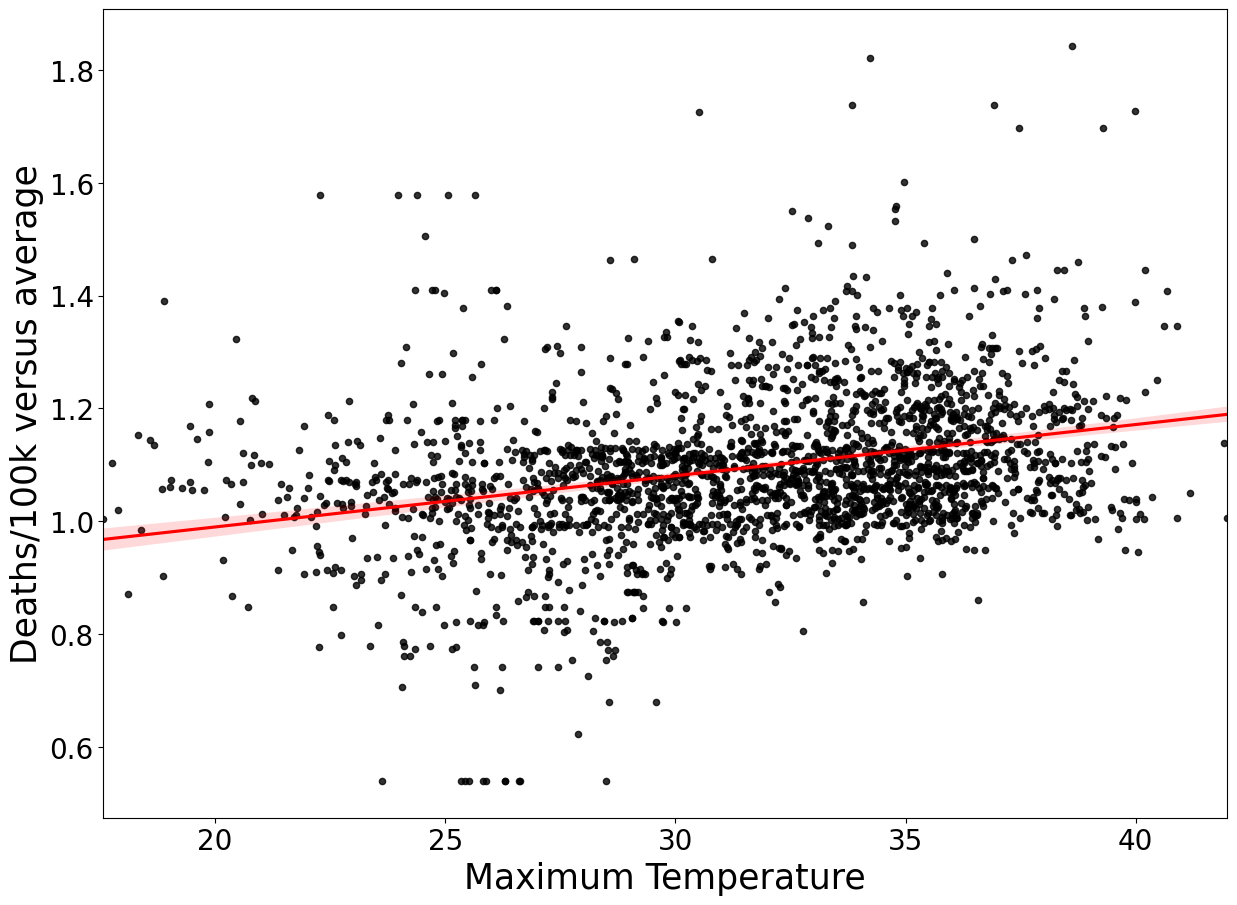

In [15]:
ax = sns.regplot(x="max_apparent_temperature", y="death_p_100k_vs_avg", data=heatwave,
                 scatter_kws={"color": "black",'s':20}, line_kws={"color": "red"})
ax.figure.set_size_inches(14.5, 10.5)
ax.set_xlabel('Maximum Temperature', fontsize=25)
ax.set_ylabel('Deaths/100k versus average', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [16]:
heatwave['max_apparent_temperature'].corr(heatwave['death_p_100k_vs_avg'])

0.3015580016332252

In [17]:
# filter MRT for better visualization
z = heatwave[heatwave['MRT_4PM'] > 20]

## Descriptive plots of mortlality versus MRT

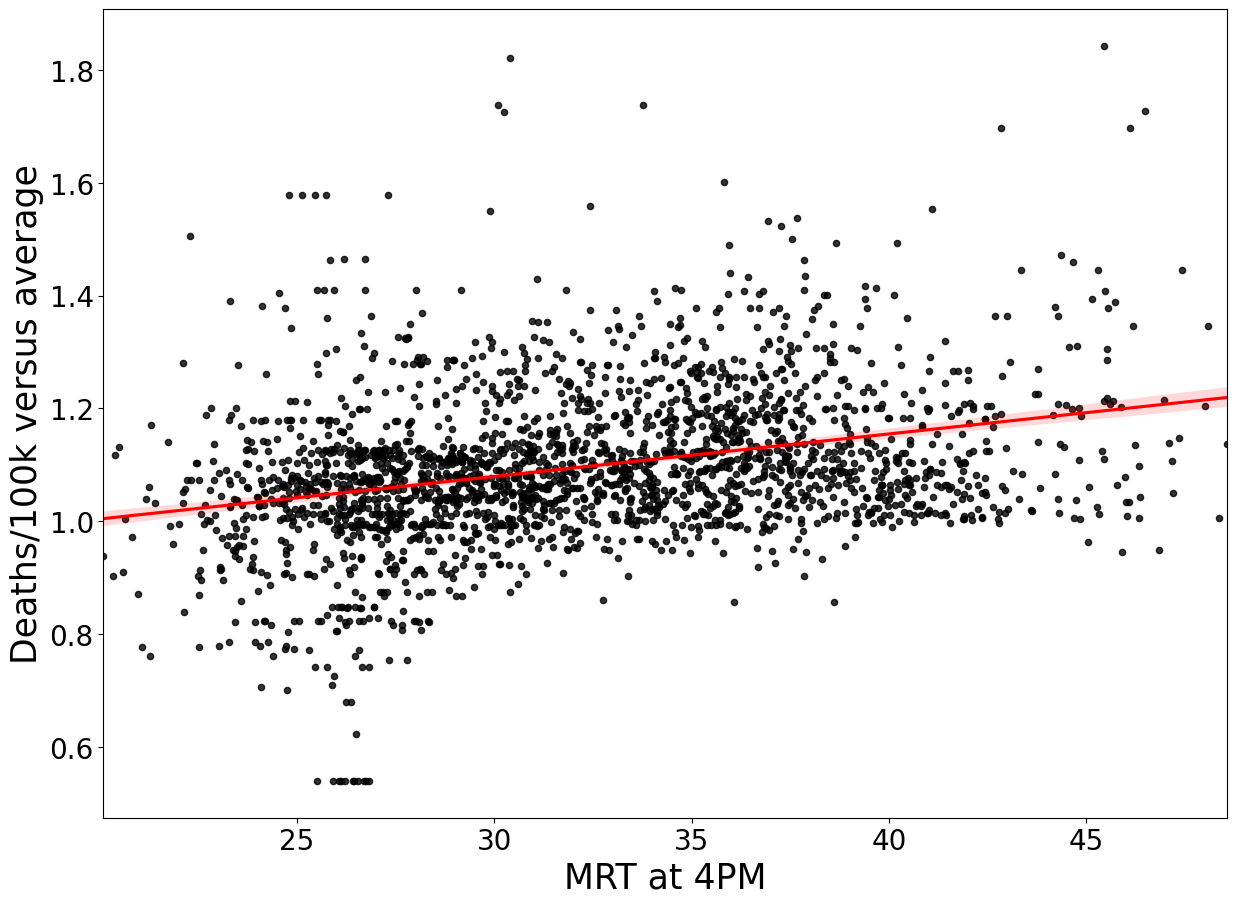

In [18]:
ax = sns.regplot(x="MRT_4PM", y="death_p_100k_vs_avg", data=z,
                 scatter_kws={"color": "black",'s':20}, line_kws={"color": "red"})
ax.figure.set_size_inches(14.5, 10.5)
ax.set_xlabel('MRT at 4PM', fontsize=25)
ax.set_ylabel('Deaths/100k versus average', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [19]:
# get correlation
z['MRT_4PM'].corr(z['death_p_100k_vs_avg'])

0.31270393265935176

In [20]:
# inspect shape
heatwave.shape

(2401, 114)

# Outlier Detection

In [21]:
# define random_state for the analysis
random_state = 3

In [22]:
# split data into train and test for outlier detection, without removing the original outcome of relative mortality
train, test,  = train_test_split(heatwave, train_size = 0.75, random_state = random_state)
print("There are {} samples in the training dataset".format(train.shape[0]))
print("There are {} samples in the testing dataset".format(test.shape[0]))
print("Each sample has {} features".format(train.shape[1]))

There are 1800 samples in the training dataset
There are 601 samples in the testing dataset
Each sample has 114 features


## Univariate Outlier Detection on outcome based on IQR

In [23]:
# get IQR
train['death_p_100k_vs_avg'].describe()

count    1800.000000
mean        1.096499
std         0.137466
min         0.539390
25%         1.021416
50%         1.083237
75%         1.161193
max         1.842541
Name: death_p_100k_vs_avg, dtype: float64

In [24]:
# get thresholds for outliers
a = 1.161193 + 1.5*(1.161193 - 1.021416)
b = 1.021416 - 1.5*(1.161193 - 1.021416)
print(a)
print(b)

1.3708584999999998
0.8117505000000004


In [25]:
# get train
train.shape

(1800, 114)

In [26]:
# histogram of outcome
hist = train['death_p_100k_vs_avg'].hist(bins=20)

In [27]:
# histogram
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.boxplot(x=train["death_p_100k_vs_avg"])
ax.set_xlabel('Deaths/100k versus average', fontsize=20)
ax.tick_params(labelsize=16)

In [28]:
# remove heat waves with outlying  mortality
train = train[(train['death_p_100k_vs_avg'] > 0.81) & (train['death_p_100k_vs_avg'] < 1.3708584999999998)]
train.shape

(1703, 114)

In [29]:
test.shape

(601, 114)

In [30]:
# use same thresholds to remove them from the test set
test = test[(test['death_p_100k_vs_avg'] > 0.81) & (test['death_p_100k_vs_avg'] < 1.3708584999999998)]
test.shape

(573, 114)

## Outlier Detection using Isolation Forest

In [31]:
# run isolation forest without contamination parameter
isol = IsolationForest(n_estimators=2000, random_state=random_state).fit(train)

train['outlier_score'] = isol.decision_function(train)

train['outlier_score'].describe()

count    1703.000000
mean        0.126179
std         0.012350
min         0.057905
25%         0.119370
50%         0.128535
75%         0.134739
max         0.151469
Name: outlier_score, dtype: float64

No outliers observed.

In [32]:
# drop outlier score of Isolation Forest
train = train.drop(['outlier_score'], 1)

In [33]:
# run isolation forest with contamination parameter
isol = IsolationForest(n_estimators=2000,contamination=0.03, random_state=random_state).fit(train)

train['outlier_score'] = isol.decision_function(train)

train['outlier_score'].describe()

X does not have valid feature names, but IsolationForest was fitted with feature names


count    1703.000000
mean        0.029626
std         0.012350
min        -0.038648
25%         0.022817
50%         0.031982
75%         0.038186
max         0.054917
Name: outlier_score, dtype: float64

In [40]:
# add labels
train['outlier_score'] = np.where(train['outlier_score'] < 0, 'Outlier', 'No Outlier')

In [41]:
# show value counts
train['outlier_score'].value_counts()

No Outlier    1651
Outlier         52
Name: outlier_score, dtype: int64

[Text(0, 0.5, 'Deaths/100k versus average')]

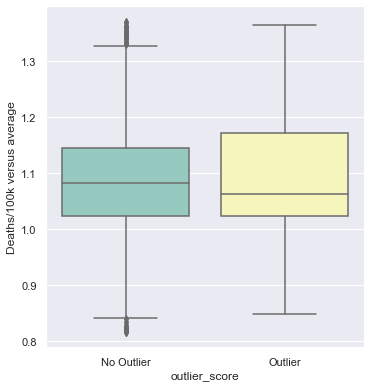

In [43]:
# plot outlier boxplots versus non-outlier boxplots
sns.set(rc={'figure.figsize':(5.7,6.27)})
#sns.set_theme(style='white')
ax = sns.boxplot(y="death_p_100k_vs_avg", x="outlier_score",
                 data=train, palette="Set3")
ax.set(ylabel = "Deaths/100k versus average")

[Text(0, 0.5, 'Maximum Temperature')]

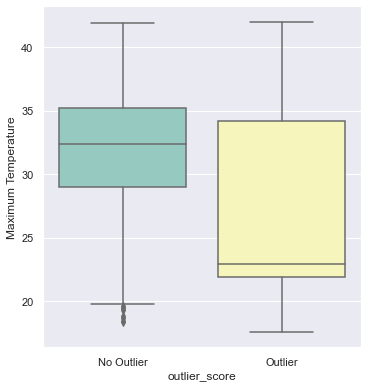

In [44]:
# plot outlier boxplots versus non-outlier boxplots
ax = sns.boxplot(y="max_apparent_temperature", x="outlier_score",
                 data=train, palette="Set3")
ax.set(ylabel = "Maximum Temperature")

In [45]:
# predict outlying scores for test
isol_predicted = isol.predict(test)

In [46]:
# include outlier score in test set
test = test.reset_index()
test = test.drop(['index'],1)
test['outlier_score'] = pd.Series(isol_predicted)

In [48]:
# count outliers in test
test['outlier_score'].value_counts()

 1    557
-1     16
Name: outlier_score, dtype: int64

In [49]:
# relabel outliers to binary variables
train['outlier_score'] = np.where(train['outlier_score'] == 'Outlier', 1, 0)
test['outlier_score'] = np.where(test['outlier_score'] == -1, 1, 0)

In [50]:
# run auxiliary random forest model
train_feat = train.drop('outlier_score', 1)
train_out = train['outlier_score']
test_feat = test.drop('outlier_score', 1)
test_out = test['outlier_score']

clf = RandomForestClassifier(max_depth=6, random_state=random_state, n_estimators=1000).fit(train_feat, train_out)

In [52]:
# get train model accuracy
y_pred = clf.predict(train_feat)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(train_out, y_pred)))

Model accuracy score : 0.9930


In [53]:
# get test model accuracy
y_pred = clf.predict(test_feat)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(test_out, y_pred)))

Model accuracy score : 0.9878


In [53]:
# get permutation importance of features
result = permutation_importance(clf, train_feat, train_out, n_repeats=10,scoring = 'accuracy', random_state=random_state)

In [66]:
# 10 iterations of permutations per feature
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=train_feat.columns[sorted_importances_idx],
)

In [67]:
importances

max_apparent_temperature  country_is_AL  region_is_NL2  region_is_NL1  \
0                  0.000000            0.0            0.0            0.0   
1                  0.000000            0.0            0.0            0.0   
2                  0.000000            0.0            0.0            0.0   
3                  0.000000            0.0            0.0            0.0   
4                  0.000000            0.0            0.0            0.0   
5                  0.000000            0.0            0.0            0.0   
6                 -0.000587            0.0            0.0            0.0   
7                  0.000000            0.0            0.0            0.0   
8                  0.000000            0.0            0.0            0.0   
9                  0.000000            0.0            0.0            0.0   

   region_is_ITI  region_is_ITH  region_is_ITG  region_is_ITF  region_is_ITC  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   
6            0.0            0.0            0.0            0.0            0.0   
7            0.0            0.0            0.0            0.0            0.0   
8            0.0            0.0            0.0            0.0            0.0   
9            0.0            0.0            0.0            0.0            0.0   

   region_is_HU3  region_is_HU2  region_is_HU1  region_is_FRL  region_is_FRK  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   
6            0.0            0.0            0.0            0.0            0.0   
7            0.0            0.0            0.0            0.0            0.0   
8            0.0            0.0            0.0            0.0            0.0   
9            0.0            0.0            0.0            0.0            0.0   

   region_is_FRJ  region_is_FRI  region_is_FRH  region_is_FRG  region_is_FRF  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   
6            0.0            0.0            0.0            0.0            0.0   
7            0.0            0.0            0.0            0.0            0.0   
8            0.0            0.0            0.0            0.0            0.0   
9            0.0            0.0            0.0            0.0            0.0   

   region_is_FRE  region_is_NL3  region_is_NL4  region_is_PL2  region_is_PL4  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            

In [68]:
# show 3 features with highest median importance
importances_copy = importances.copy()
importances_copy.loc['median'] = importances_copy.median()
importances_copy = importances_copy.T
importances_copy = importances_copy.sort_values(by=['median'], ascending=False).head(3)
importances_copy

0         1         2         3  \
min_apparent_temperature_vs_avg  0.007046  0.007046  0.007046  0.007046   
MRT_4PM_vs_avg                   0.001762  0.001762  0.001762  0.001762   
max_apparent_temperature_vs_avg  0.001762  0.001762  0.001174  0.001762   

                                        4         5         6         7  \
min_apparent_temperature_vs_avg  0.006459  0.007046  0.006459  0.007046   
MRT_4PM_vs_avg                   0.001762  0.001762  0.001762  0.001762   
max_apparent_temperature_vs_avg  0.001174  0.001762  0.001762  0.001762   

                                        8         9    median  
min_apparent_temperature_vs_avg  0.006459  0.007046  0.007046  
MRT_4PM_vs_avg                   0.001762  0.001762  0.001762  
max_apparent_temperature_vs_avg  0.001762  0.001762  0.001762

In [69]:
# print feature names
index = importances_copy.index
a_list = list(index)
print(a_list)

['min_apparent_temperature_vs_avg', 'MRT_4PM_vs_avg', 'max_apparent_temperature_vs_avg']


In [70]:
# keep only important features
importances = importances.drop(columns=[col for col in importances if col not in a_list])
importances

max_apparent_temperature_vs_avg  MRT_4PM_vs_avg  \
0                         0.001762        0.001762   
1                         0.001762        0.001762   
2                         0.001174        0.001762   
3                         0.001762        0.001762   
4                         0.001174        0.001762   
5                         0.001762        0.001762   
6                         0.001762        0.001762   
7                         0.001762        0.001762   
8                         0.001762        0.001762   
9                         0.001762        0.001762   

   min_apparent_temperature_vs_avg  
0                         0.007046  
1                         0.007046  
2                         0.007046  
3                         0.007046  
4                         0.006459  
5                         0.007046  
6                         0.006459  
7                         0.007046  
8                         0.006459  
9                         0.007046

Text(0.5, 0, 'Decrease in accuracy score')

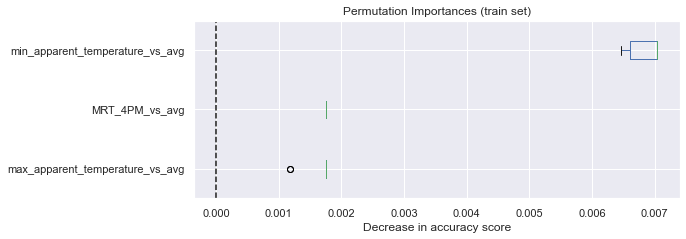

In [72]:
# plot importances
sns.set(rc={'figure.figsize':(8.7,3.27)})
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
#ax.figure.tight_layout()

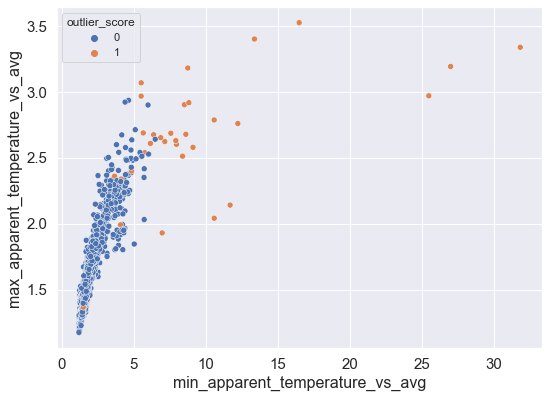

In [60]:
# visualize outliers on important explanatory variables
sns.set(rc={'figure.figsize':(8.7,6.27)})
sns.scatterplot(data=train, x="min_apparent_temperature_vs_avg", y="max_apparent_temperature_vs_avg", hue="outlier_score")
plt.xlabel('min_apparent_temperature_vs_avg', fontsize=16);
plt.ylabel('max_apparent_temperature_vs_avg', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=15)

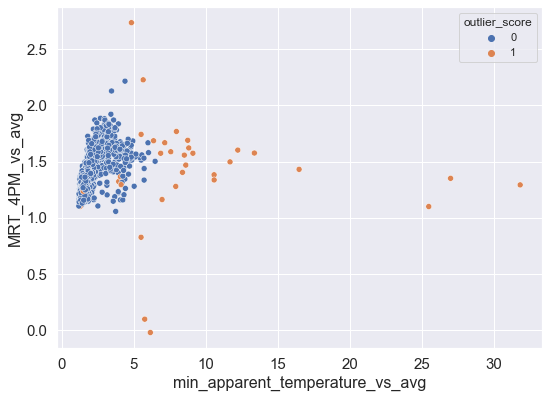

In [64]:
# visualize outliers on important explanatory variables
sns.set(rc={'figure.figsize':(8.7,6.27)})
sns.scatterplot(data=train, x="min_apparent_temperature_vs_avg", y="MRT_4PM_vs_avg", hue="outlier_score")
plt.xlabel('min_apparent_temperature_vs_avg', fontsize=16);
plt.ylabel('MRT_4PM_vs_avg', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=15)

## Removing outliers

In [54]:
# from training
train = train[train['outlier_score'] != 1]
train

country_is_AL  country_is_AT  country_is_BE  country_is_BG  \
183               0              1              0              0   
2623              0              0              0              0   
2515              0              0              0              0   
2959              0              0              0              0   
2058              0              0              0              0   
...             ...            ...            ...            ...   
985               0              0              0              0   
1260              0              0              0              0   
2449              0              0              0              0   
2482              0              0              0              0   
2755              0              0              0              0   

      country_is_CH  country_is_CZ  country_is_DK  country_is_EE  \
183               0              0              0              0   
2623              0              0              0              0   
2515              0              0              0              0   
2959              0              0              0              0   
2058              0              0              0              0   
...             ...            ...            ...            ...   
985               0              0              0              0   
1260              0              0              0              0   
2449              0              0              0              0   
2482              0              0              0              0   
2755              0              0              0              0   

      country_is_EL  country_is_ES  country_is_FI  country_is_FR  \
183               0              0              0              0   
2623              0              0              0              1   
2515              0              0              0              1   
2959              0              0              0              0   
2058              0              0              1              0   
...             ...            ...            ...            ...   
985               0              0              0              0   
1260              0              0              1              0   
2449              0              0              0              1   
2482              0              0              0              1   
2755              0              0              0              0   

      country_is_HU  country_is_IT  country_is_LT  country_is_LU  \
183               0              0              0              0   
2623              0              0              0              0   
2515              0              0              0              0   
2959              0              1              0              0   
2058              0              0              0              0   
...             ...            ...            ...            ...   
985               0              0              0              0   
1260              0              0              0              0   
2449              0              0              0              0   
2482              0              0              0              0   
2755              0              1              0              0   

      country_is_LV  country_is_ME  country_is_NL  country_is_NO  \
183               0              0              0              0   
2623              0              0              0              0   
2515              0              0              0              0   
2959              0              0              0              0   
2058              0              0              0              0   
...             ...            ...            ...            ...   
985               0              0              0              0   
1260              0              0              0              0   
2449              0              0              0              0   
2482              0              0              0         

In [55]:
# split into explanatory features and outcome and drop outlier score
X_train = train.drop(['death_p_100k_vs_avg', 'outlier_score'], 1)
y_train = train['death_p_100k_vs_avg']

In [56]:
# for test
test = test[test['outlier_score'] != 1]
test

country_is_AL  country_is_AT  country_is_BE  country_is_BG  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   
..             ...            ...            ...            ...   
568              0              0              0              0   
569              0              0              0              0   
570              0              0              0              0   
571              0              0              0              0   
572              0              0              0              0   

     country_is_CH  country_is_CZ  country_is_DK  country_is_EE  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   
..             ...            ...            ...            ...   
568              0              0              0              0   
569              0              0              0              0   
570              0              0              0              0   
571              0              0              0              0   
572              0              0              0              0   

     country_is_EL  country_is_ES  country_is_FI  country_is_FR  \
0                0              1              0              0   
1                0              1              0              0   
2                0              0              1              0   
3                0              0              0              0   
4                0              0              0              0   
..             ...            ...            ...            ...   
568              0              0              0              0   
569              0              0              0              0   
570              0              0              0              0   
571              0              0              0              0   
572              0              0              0              0   

     country_is_HU  country_is_IT  country_is_LT  country_is_LU  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   
..             ...            ...            ...            ...   
568              0              0              0              0   
569              0              0              0              0   
570              0              0              0              0   
571              0              0              0              0   
572              1              0              0              0   

     country_is_LV  country_is_ME  country_is_NL  country_is_NO  \
0                0              0              0              0   
1                0              0              0              0   
2                0              0              0              0   
3                0              0              0              0   
4                0              0              0              0   
..             ...            ...            ...            ...   
568              0              0              0              1   
569              0              0              0              0   
570              1              0              0              0   
571              0              0              0              0   
572              0              0              0

In [57]:
# split into explanatory features and outcome and drop outlier score
X_test = test.drop(['death_p_100k_vs_avg', 'outlier_score'], 1)
y_test = test['death_p_100k_vs_avg']

In [58]:
# overview
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 1651 samples in the training dataset
There are 557 samples in the testing dataset
Each sample has 113 features


# Modelling with Decision Tree

In [60]:
# restrict max depth of decision tree in order to have a good visualization
parameter_values = range(1,4)

In [61]:
# run gridsearch over possible values of max depth and return best score
parameters = {'max_depth':parameter_values}
tree_reg = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=4)
tree_reg.fit(X_train, y_train)
tree_model = tree_reg.best_estimator_
print (tree_reg.best_score_, tree_reg.best_params_) 

0.11623805547710017 {'max_depth': 3}


In [62]:
# plot decision tree
sns.reset_defaults()
figure(figsize = (100,100))
plot_tree(tree_model,
           fontsize=60
          , filled=True
         , feature_names = X_train.columns
         , class_names = ['true', 'false']
          , rounded = True
          , proportion = True
         );

# Random Forest Regression

In [415]:
# set wide range of parameters for first randomized grid search
# Number of trees in random forest
n_estimators = [1500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.5, 0.75]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 90, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 8, 15, 20,45, 60, 100]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [1500], 'max_features': ['auto', 'sqrt', 0.5, 0.75], 'max_depth': [1, 12, 23, 34, 45, 56, 67, 78, 90, None], 'min_samples_split': [2, 10, 50], 'min_samples_leaf': [1, 8, 15, 20, 45, 60, 100]}


In [416]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose=2, random_state=random_state,
                               n_jobs = -1,
                               scoring = 'r2',
                              return_train_score=True)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 12, 23, 34, 45, 56, 67,
                                                      78, 90, None],
                                        'max_features': ['auto', 'sqrt', 0.5,
                                                         0.75],
                                        'min_samples_leaf': [1, 8, 15, 20, 45,
                                                             60, 100],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [1500]},
                   random_state=3, return_train_score=True, scoring='r2',
                   verbose=2)

In [417]:
# show best parameter
rf_random.best_params_

{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 0.75,
 'max_depth': 67}

In [420]:
# show cross validation score
round(rf_random.best_score_,3)

0.429

In [425]:
# show training score
round(rf_random.score(X_train, y_train),4)

0.9298

Strong indication of overfitting. Therefore, it will be tried to reduce the complexity by restricting the parameters.

In [428]:
# running similar model aith parameter ranges restricted to be less complex
param_grid = {
    'bootstrap': [True],
    'max_depth': [4,13,30],
    'max_features': ['auto', 'sqrt', 0.75],
    'min_samples_leaf': [4,10],
    'min_samples_split': [2,10],
    'n_estimators': [1500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.4min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 13, 30],
                         'max_features': ['auto', 'sqrt', 0.75],
                         'min_samples_leaf': [4, 10],
                         'min_samples_split': [2, 10], 'n_estimators': [1500]},
             verbose=2)

In [429]:
# print best parameter combination and score
print(grid_search.best_params_)
print(round(grid_search.best_score_,3))

{'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1500}
0.413


In [430]:
# print training score
grid_search.score(X_train, y_train)

0.8288866482470335

Still, strong overfitting is observed. Hence, feature selection is consulted as a method to reduce overfitting.

In [431]:
# running the proposed model again to extract feature importances
regr = RandomForestRegressor(max_depth=30, random_state=random_state, n_estimators=1500, min_samples_split = 2, min_samples_leaf= 4, max_features = 'auto').fit(X_train,y_train)

In [432]:
# getting feature importances for feature selection
regr.feature_importances_  
model = SelectFromModel(regr, prefit=True)
X_new = model.transform(X_train)
X_new.shape

(1651, 24)

Only 24 features are part of the reduced dataframe.

In [433]:
# getting feature names
regr.feature_importances_  
model = SelectFromModel(regr, prefit=True)
feature_idx = model.get_support()
feature_name = X_train.columns[feature_idx]
print(feature_name)

Index(['latitude', 'longitude', 'min_apparent_temperature',
       'min_apparent_temperature_vs_avg', 'max_apparent_temperature',
       'max_apparent_temperature_vs_avg', 'uvb_4PM', 'uvb_4PM_vs_avg',
       'wind_day', 'wind_day_vs_avg', 'dew_point_day', 'dew_point_day_vs_avg',
       'MRT_2AM', 'MRT_2AM_vs_avg', 'MRT_4PM', 'MRT_4PM_vs_avg', 'month',
       'year', 'length', 'health_expend_p_capita',
       'Chronic_lower_respiratory_diseases', 'High_blood_pressure',
       'share_over_64', 'population_density'],
      dtype='object')


In [434]:
# create new reduced dataframe: training
X_train_new = pd.DataFrame(X_new)
X_train_new.columns = feature_name
X_train_new

latitude  longitude  min_apparent_temperature  \
0        46.75      12.50                  9.290000   
1        46.75       5.75                 20.435000   
2        46.00       3.50                 18.992500   
3        43.00      12.50                 21.601429   
4        61.75      27.50                 21.136667   
...        ...        ...                       ...   
1646     43.75      20.00                 16.710000   
1647     60.25      22.25                 19.437500   
1648     43.75       2.00                 24.118000   
1649     45.25       2.75                 12.707500   
1650     44.50       8.75                 25.376000   

      min_apparent_temperature_vs_avg  max_apparent_temperature  \
0                            2.499662                 20.837500   
1                            1.745745                 31.882500   
2                            1.622888                 33.492500   
3                            1.433219                 35.022857   
4                            2.543116                 30.501667   
...                               ...                       ...   
1646                         1.603465                 34.625000   
1647                         1.998184                 27.952500   
1648                         1.626261                 35.652000   
1649                         1.513013                 28.865000   
1650                         1.470932                 33.394000   

      max_apparent_temperature_vs_avg        uvb_4PM  uvb_4PM_vs_avg  \
0                            1.634562  130909.065000        1.271990   
1                            1.515950  189474.890000        1.353252   
2                            1.498605  211660.250000        1.436272   
3                            1.351012  142925.445714        1.133401   
4                            1.916476  119924.785000        1.744907   
...                               ...            ...             ...   
1646                         1.540664   87420.287500        1.013910   
1647                         1.752652  130091.343750        1.438680   
1648                         1.433292  199622.294000        1.187318   
1649                         1.605650  181831.617500        1.174856   
1650                         1.397216  140565.072000        1.013336   

      wind_day  wind_day_vs_avg  dew_point_day  dew_point_day_vs_avg  \
0     0.516875         1.176599      10.775000              1.791935   
1     1.411250         0.999093      15.441250              1.395695   
2     0.919375         0.672177      14.885000              1.364995   
3     1.017857         0.837552      15.567857              1.241565   
4     1.658333         0.876047      16.947083              1.933629   
...        ...              ...            ...                   ...   
1646  0.825000         0.848545      14.738750              1.263591   
1647  1.555313         0.583971      16.166250              1.685448   
1648  1.617000         0.704807      18.779000              1.425274   
1649  0.851250         0.481467      11.225000              1.184806   
1650  0.455500         0.564137      19.575000              1.312868   

        MRT_2AM  MRT_2AM_vs_avg    MRT_4PM  MRT_4PM_vs_avg  month    year  \
0      4.707500        8.545215  20.392500        1.104643    8.0  2016.0   
1     12.860000        1.775331  35.162500        1.329379    6.0  2017.0   
2     12.187500        1.670470  37.212500        1.306416    6.0  2017.0   
3     14.805714        1.684873  36.685714        1.272420    8.0  2021.0   
4     16.011667        2.891747  28.095000        1.694870    7.0  2010.0   
...         ...             ...        ...             ...    ...     ...   
1646  10.805000        1.609625  30.847500        1.360949    8.0  2007.0   
1647  12.073750        2.102313  26.160000        1.563481    7.0  2014.0   
1648  16.080000        1.615242  39.132000        1.247555    8.0  2018.0   
1649   6.337500        1.366955  29.6525

In [87]:
# create new reduced dataframe: test
X_test_new = X_test[feature_name]
X_test_new

latitude  longitude  min_apparent_temperature  \
0       40.75      -6.25                 18.642500   
1       42.25      -8.50                 23.328000   
2       61.00      24.50                 18.390000   
3       48.25      26.75                 20.737500   
4       48.25      26.75                 23.514000   
..        ...        ...                       ...   
568     65.50      13.25                 14.431111   
569     61.75      12.50                 12.888000   
570     55.75      26.75                 18.362500   
571     52.00      23.00                 22.615000   
572     47.50      17.00                 22.225714   

     min_apparent_temperature_vs_avg  max_apparent_temperature  \
0                           1.529417                 33.920000   
1                           1.745433                 35.240000   
2                           2.342494                 30.314000   
3                           1.511494                 35.147500   
4                           1.713865                 35.766000   
..                               ...                       ...   
568                         4.336016                 25.543333   
569                         4.105194                 26.488000   
570                         1.926760                 31.830000   
571                         2.158070                 33.902500   
572                         1.552498                 36.297143   

     max_apparent_temperature_vs_avg        uvb_4PM  uvb_4PM_vs_avg  wind_day  \
0                           1.453880  270377.090000        1.159130  1.806875   
1                           1.581162  302006.232000        1.330028  1.867000   
2                           1.839836  111532.754000        1.503000  2.213500   
3                           1.447055   96660.890000        1.423717  1.358750   
4                           1.472520   84949.746000        1.251223  0.952500   
..                               ...            ...             ...       ...   
568                         2.376791  149651.745556        1.642357  1.378056   
569                         2.250549  158088.778000        1.635775  1.432000   
570                         1.691295   89240.252500        1.350946  2.060000   
571                         1.624623   83298.255000        1.132331  1.407500   
572                         1.521100  135636.707143        1.405789  0.661429   

     wind_day_vs_avg  dew_point_day  dew_point_day_vs_avg    MRT_2AM  \
0           0.961407       9.134375              1.067872  10.762500   
1           1.110853      17.154500              1.294292  12.198000   
2           1.182807      16.843000              1.928362  14.554000   
3           0.797506      15.891250              1.352228  15.682500   
4           0.559061      15.669500              1.333358  17.336000   
..               ...            ...                   ...        ...   
568         0.892124      12.725556              2.313904   7.515556   
569         0.931443      12.418500              2.486869   7.188000   
570         0.964514      15.199375              1.475393  13.527500   
571         0.630991      17.785000              1.670116  15.840000   
572         0.525531      16.144286              1.314313  15.680000   

     MRT_2AM_vs_avg    MRT_4PM  MRT_4PM_vs_avg  month  year  length  \
0          1.782960  39.412500        1.222383   8.00  2021       4   
1          1.594604  37.522000        1.246699   7.00  2013       5   
2          2.865731  30.270000        1.744029   7.00  2010       5   
3          1.681736  33.025000        1.391714   7.00  2015       4   
4          1.859051  34.904000        1.470897   8.00  2017       5   
..              ...        ...             ...    ...   ...     ...   
568        4.842114  26.947778        1.577220   7.00  2014       9   
569        7.793825  26.622000        1.571022   7.00  2019       5   
570        2.062893  29.597500        1.529513   7.25  2002       4   
571        2.21

In [436]:
# running similar model on the reduced dataframe
param_grid = {
    'bootstrap': [True],
    'max_depth': [4,13,30],
    'max_features': ['auto', 0.5],
    'min_samples_leaf': [4,10],
    'min_samples_split': [2,10],
    'n_estimators': [1500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the random search model
grid_search.fit(X_train_new, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.0min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 13, 30],
                         'max_features': ['auto', 0.5],
                         'min_samples_leaf': [4, 10],
                         'min_samples_split': [2, 10], 'n_estimators': [1500]},
             verbose=2)

In [437]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1500}

In [438]:
print(grid_search.best_params_)
print(round(grid_search.best_score_,3))

{'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1500}
0.41


In [439]:
grid_search.score(X_train_new, y_train)

0.8268581383098058

No improvement is observed. Hence, feature selection is extended by deleting even more features.

In [440]:
regr = RandomForestRegressor(max_depth=30, random_state=random_state, n_estimators=1500, min_samples_split = 2, min_samples_leaf= 4, max_features = 'auto').fit(X_train_new,y_train)

In [441]:
# further reduction of feature number
regr.feature_importances_  
model = SelectFromModel(regr, prefit=True)
X_train_new2 = model.transform(X_train_new)
X_train_new2.shape

(1651, 11)

In [442]:
# print names
regr.feature_importances_  
model = SelectFromModel(regr, prefit=True)
feature_idx = model.get_support()
feature_name = X_train_new.columns[feature_idx]
print(feature_name)

Index(['latitude', 'min_apparent_temperature', 'max_apparent_temperature',
       'uvb_4PM', 'uvb_4PM_vs_avg', 'MRT_4PM', 'year', 'length',
       'health_expend_p_capita', 'share_over_64', 'population_density'],
      dtype='object')


In [443]:
# create dataframe of it
X_train_new2 = pd.DataFrame(X_train_new2)
X_train_new2.columns = feature_name
X_train_new2

latitude  min_apparent_temperature  max_apparent_temperature  \
0        46.75                  9.290000                 20.837500   
1        46.75                 20.435000                 31.882500   
2        46.00                 18.992500                 33.492500   
3        43.00                 21.601429                 35.022857   
4        61.75                 21.136667                 30.501667   
...        ...                       ...                       ...   
1646     43.75                 16.710000                 34.625000   
1647     60.25                 19.437500                 27.952500   
1648     43.75                 24.118000                 35.652000   
1649     45.25                 12.707500                 28.865000   
1650     44.50                 25.376000                 33.394000   

            uvb_4PM  uvb_4PM_vs_avg    MRT_4PM    year  length  \
0     130909.065000        1.271990  20.392500  2016.0     4.0   
1     189474.890000        1.353252  35.162500  2017.0     4.0   
2     211660.250000        1.436272  37.212500  2017.0     4.0   
3     142925.445714        1.133401  36.685714  2021.0     7.0   
4     119924.785000        1.744907  28.095000  2010.0     6.0   
...             ...             ...        ...     ...     ...   
1646   87420.287500        1.013910  30.847500  2007.0     4.0   
1647  130091.343750        1.438680  26.160000  2014.0     8.0   
1648  199622.294000        1.187318  39.132000  2018.0     5.0   
1649  181831.617500        1.174856  29.652500  2016.0     4.0   
1650  140565.072000        1.013336  34.306000  2012.0     5.0   

      health_expend_p_capita  share_over_64  population_density  
0                4237.370000      17.444486                59.3  
1                3890.450000      20.498228                72.7  
2                3890.450000      23.534039                52.4  
3                2678.712153      25.950251               105.5  
4                3206.970000      22.770612                11.2  
...                      ...            ...                 ...  
1646              243.085312      19.678059                73.6  
1647             3705.370000      21.778890                36.9  
1648             3939.610000      21.583629                67.5  
1649             3841.060000      22.997935                52.3  
1650             2396.320000      27.315086               293.9  

[1651 rows x 11 columns]

In [196]:
# same for test
X_test_new2 = X_test_new[feature_name]
X_test_new2

uvb_4PM  uvb_4PM_vs_avg  wind_day_vs_avg  MRT_4PM  year  \
0    270377.090000        1.159130         0.961407  39.4125  2021   
1    302006.232000        1.330028         1.110853  37.5220  2013   
2    111532.754000        1.503000         1.182807  30.2700  2010   
3     96660.890000        1.423717         0.797506  33.0250  2015   
4     84949.746000        1.251223         0.559061  34.9040  2017   
..             ...             ...              ...      ...   ...   
596   89240.252500        1.350946         0.964514  29.5975  2002   
597  149510.327500        1.643370         0.825551  27.7850  2019   
598   83298.255000        1.132331         0.630991  31.4675  2010   
599  194728.494000        1.502295         0.894211  38.4300  2015   
600  135636.707143        1.405789         0.525531  36.1100  2013   

     health_expend_p_capita  share_over_64  population_density  
0               2562.336770      25.514522                25.6  
1               1984.380000      23.108347                93.9  
2               3206.970000      18.978991                36.4  
3                399.830000      16.832375                90.4  
4                493.750000      17.493934                89.5  
..                      ...            ...                 ...  
596              273.608114      15.421835                37.1  
597             5041.770000      23.830995                15.8  
598              577.828894      15.549990                85.8  
599             3781.720000      17.179589               227.7  
600              747.640000      17.260187                86.9  

[573 rows x 8 columns]

In [448]:
# running similar model on the reduced dataframe
param_grid = {
    'bootstrap': [True],
    'max_depth': [4,13,30],
    'max_features': ['auto', 0.5],
    'min_samples_leaf': [4,10],
    'min_samples_split': [2,10],
    'n_estimators': [1500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the random search model
grid_search.fit(X_train_new2, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.6min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 13, 30],
                         'max_features': ['auto', 0.5],
                         'min_samples_leaf': [4, 10],
                         'min_samples_split': [2, 10], 'n_estimators': [1500]},
             verbose=2)

In [449]:
print(grid_search.best_params_)
print(round(grid_search.best_score_,3))

{'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1500}
0.418


In [450]:
grid_search.score(X_train_new2, y_train)

0.8015016297151502

In [201]:
grid_search.score(X_test_new2, y_test)

0.42853246156542424

Still no improvement, feature selection is not considered the right way to tackle overfitting. Instead the model will be generalized by trimming down the maximum depth parameter of the trees grown in random forest to simplify the model.

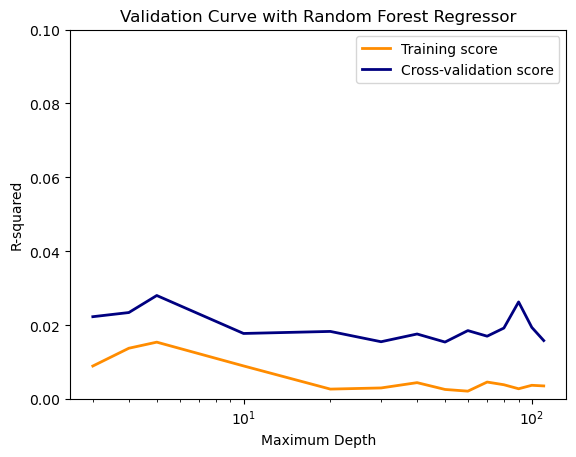

In [177]:
# 
import matplotlib.pyplot as plt



param_range = [3,4,5,10,20,30,40,50,60,70,80,90,100,110]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(),
    X_train_new,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="r2",
    n_jobs=2,
    cv=3
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest Regressor")
plt.xlabel("Maximum Depth")
plt.ylabel("R-squared")
plt.ylim(0, 0.1)
#plt.xlim(0, 120)
lw = 2
plt.semilogx(
    param_range, train_scores_std, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_std, label="Cross-validation score", color="navy", lw=lw
)
#plt.fill_between(
   # param_range,
    #test_scores_mean - test_scores_std,
    #test_scores_mean + test_scores_std,
   # alpha=0.2,
    #color="navy",
   # lw=lw,
#)
plt.legend(loc="best")
plt.show()

In [456]:
train_scores_mean

array([0.30639422, 0.47626381, 0.75797879, 0.81883037, 0.81829742,
       0.81879542, 0.8188046 , 0.8188604 , 0.81868723, 0.8187319 ])

In [473]:
import matplotlib.pyplot as plt
import numpy as np




param_range = [3,5,10,25,40,55,70,85,100,113]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(min_samples_leaf = 4, min_samples_split =  2, n_estimators = 1500),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="r2",
    n_jobs=2,
    cv=5
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

KeyboardInterrupt: 

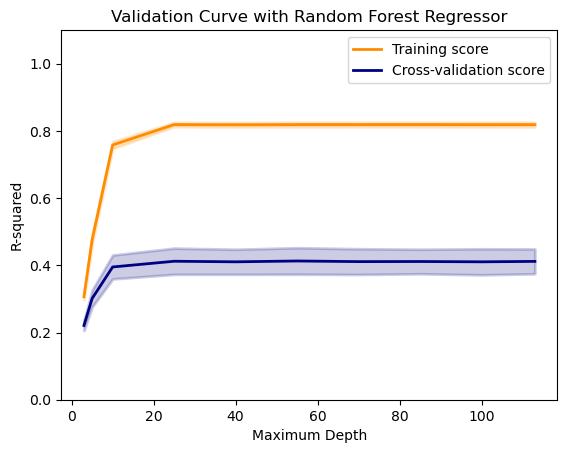

In [474]:
# plot training and cv-score vs maximum depth
plt.title("Validation Curve with Random Forest Regressor")
plt.xlabel("Maximum Depth")
plt.ylabel("R-squared")
plt.ylim(0, 1.1)
#plt.xlim(0, 120)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()


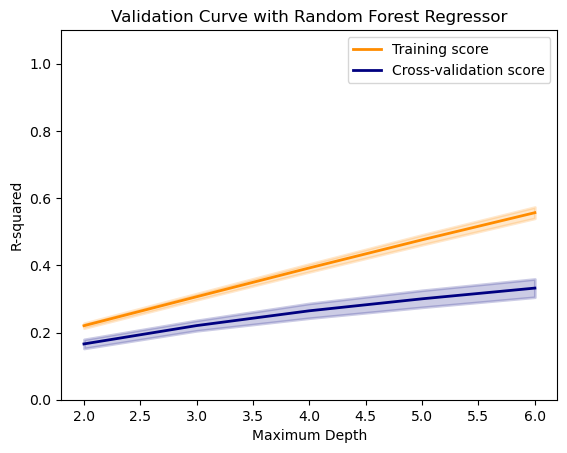

In [475]:
# plot versus small maximum depth
import matplotlib.pyplot as plt
import numpy as np



param_range = [2,3,4,5,6]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(min_samples_leaf = 4, min_samples_split =  2, n_estimators = 1500),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="r2",
    n_jobs=2,
    cv=5
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest Regressor")
plt.xlabel("Maximum Depth")
plt.ylabel("R-squared")
plt.ylim(0, 1.1)
#plt.xlim(0, 120)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.xticks(np.arange(0, 7, 1))
plt.show()

In [476]:
# plot training and cv scores versus different values of min instances in leaf nodes
import matplotlib.pyplot as plt
import numpy as np



param_range = [2,3,5,10,25,40,55,70,85,100,113]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(max_depth = 30, min_samples_split =  2, n_estimators = 1500),
    X_train,
    y_train,
    param_name="min_samples_leaf",
    param_range=param_range,
    scoring="r2",
    n_jobs=2,
    cv=5
)
train_scores_mean1 = np.mean(train_scores, axis=1)
train_scores_std1 = np.std(train_scores, axis=1)
test_scores_mean1 = np.mean(test_scores, axis=1)
test_scores_std1 = np.std(test_scores, axis=1)

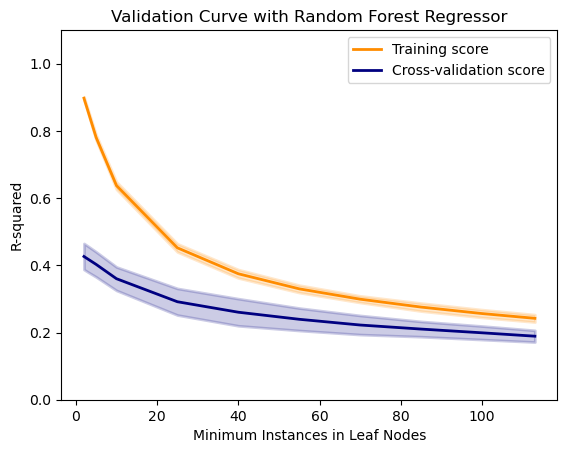

In [480]:
plt.title("Validation Curve with Random Forest Regressor")
plt.xlabel("Minimum Instances in Leaf Nodes")
plt.ylabel("R-squared")
plt.ylim(0, 1.1)
#plt.xlim(0, 120)
lw = 2
plt.plot(
    param_range, train_scores_mean1, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean1 - train_scores_std1,
    train_scores_mean1 + train_scores_std1,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean1, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean1 - test_scores_std1,
    test_scores_mean1 + test_scores_std1,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
#plt.set_xticks([0,2,4,6])
#ax.set_xticklabels(['zero','two','four','six'])
#plt.xticks([10,20,30,40,50,60,70,80,90,100,110])
plt.xticks(np.arange(0, 101, 20))
plt.show()

# Fit model with maximum depth of 4

In [491]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [4],
    'max_features': ['auto', 0.5],
    'min_samples_leaf': [1,3,4,5,6],
    'min_samples_split': [1,2,3,4],
    'n_estimators': [1500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf,
                               param_distributions = param_grid,
                               n_iter = 40,
                               cv = 5,
                               verbose=2, random_state=random_state,
                               n_jobs = -1,
                               scoring = 'r2')
# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True], 'max_depth': [4],
                                        'max_features': ['auto', 0.5],
                                        'min_samples_leaf': [1, 3, 4, 5, 6],
                                        'min_samples_split': [1, 2, 3, 4],
                                        'n_estimators': [1500]},
                   random_state=3, scoring='r2', verbose=2)

In [492]:
# print best parameters and cv score
print(grid_search.best_params_)
print(round(grid_search.best_score_,3))

{'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 4, 'bootstrap': True}
0.265


In [493]:
# print training score
grid_search.score(X_train, y_train)

0.3777150583093226

In [494]:
# print test score
grid_search.score(X_test, y_test)

0.33245280811348843

# Final Model

In [66]:
# fit final model separately in order to compute permutation importance and Shapley values
regr = RandomForestRegressor(max_depth=4, 
                             random_state=random_state,
                             n_estimators=1000, 
                             min_samples_split = 2, 
                             min_samples_leaf= 5,
                             max_features = 'auto').fit(X_train,y_train)

In [99]:
# train score
regr.score(X_train, y_train)

0.3781868546131486

In [100]:
# test score
regr.score(X_test, y_test)

0.33337751254074044

In [101]:
# print detailed model performance
train_pred = regr.predict(X_train)
test_pred = regr.predict(X_test)
print('Model training r2 score : {0:0.4f}'. format(r2_score(y_train, train_pred)))
print('Model test r2 score : {0:0.4f}'. format(r2_score(y_test, test_pred)))
print('Model training mean_squared_error : {0:0.4f}'. format(mean_squared_error(y_train, train_pred)))
print('Model test mean_squared_error : {0:0.4f}'. format(mean_squared_error(y_test, test_pred)))
print('Model training mean_absolute_error : {0:0.4f}'. format(mean_absolute_error(y_train, train_pred)))
print('Model test mean_absolute_error : {0:0.4f}'. format(mean_absolute_error(y_test, test_pred)))

Model training r2 score : 0.3782
Model test r2 score : 0.3334
Model training mean_squared_error : 0.0066
Model test mean_squared_error : 0.0072
Model training mean_absolute_error : 0.0639
Model test mean_absolute_error : 0.0651


In [564]:
# evaluating predicitons of extreme values
y_test_df = pd.DataFrame(y_test,columns=['death_p_100k_vs_avg'])
y_test_df = y_test_df.reset_index()
test_predictions = pd.DataFrame(test_pred,columns=['death_p_100k_vs_avg_predict'])
test_predictions = test_predictions.reset_index()
y_test_df['death_p_100k_vs_avg'].describe()

count    557.000000
mean       1.089122
std        0.103888
min        0.816298
25%        1.025730
50%        1.081448
75%        1.148093
max        1.363802
Name: death_p_100k_vs_avg, dtype: float64

In [565]:
# define high mortalities
y_test_high_mort = y_test_df[y_test_df['death_p_100k_vs_avg'] >= 1.148093]
y_test_high_mort.head(2)

index  death_p_100k_vs_avg
0      0             1.163299
1      1             1.277890

In [566]:
# merge high mortality with predictions
y_test_high_mort = y_test_high_mort.merge(test_predictions, on=['index'])
y_test_high_mort.head(3)

index  death_p_100k_vs_avg  death_p_100k_vs_avg_predict
0      0             1.163299                     1.106482
1      1             1.277890                     1.143405
2      5             1.179589                     1.047015

In [567]:
# print mean squared and absolute errors
print('Model mean_squared_error on top 25% deadly heat waves : {0:0.4f}'. format(mean_squared_error(y_test_high_mort['death_p_100k_vs_avg'], y_test_high_mort['death_p_100k_vs_avg_predict'])))
print('Model mean_absolute_error on top 25% deadly heat waves : {0:0.4f}'. format(mean_absolute_error(y_test_high_mort['death_p_100k_vs_avg'], y_test_high_mort['death_p_100k_vs_avg_predict'])))


Model mean_squared_error on top 25% deadly heat waves : 0.0234
Model mean_absolute_error on top 25% deadly heat waves : 0.1344


In [568]:
# define low mortality instances
y_test_low_mort = y_test_df[y_test_df['death_p_100k_vs_avg'] <= 1.025730]
y_test_low_mort.head(2)

index  death_p_100k_vs_avg
2       2             0.993339
10     10             0.993382

In [569]:
# merge real value and prediciton
y_test_low_mort = y_test_low_mort.merge(test_predictions, on=['index'])
y_test_low_mort.head(3)

index  death_p_100k_vs_avg  death_p_100k_vs_avg_predict
0      2             0.993339                     1.084540
1     10             0.993382                     1.066807
2     23             0.904760                     1.058249

In [570]:
# print mean squared and absolute errors
print('Model mean_squared_error on least 25% deadly heat waves : {0:0.4f}'. format(mean_squared_error(y_test_low_mort['death_p_100k_vs_avg'], y_test_low_mort['death_p_100k_vs_avg_predict'])))
print('Model mean_absolute_error on least 25% deadly heat waves : {0:0.4f}'. format(mean_absolute_error(y_test_low_mort['death_p_100k_vs_avg'], y_test_low_mort['death_p_100k_vs_avg_predict'])))

Model mean_squared_error on top 25% deadly heat waves : 0.0185
Model mean_absolute_error on top 25% deadly heat waves : 0.1162


In [574]:
# get permutation importances
result = permutation_importance(regr, X_train, y_train, n_repeats=10,scoring = 'r2', random_state=random_state)

In [575]:
# sort by mean
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

In [576]:
importances

country_is_AL  region_is_RO4  region_is_ES6  region_is_FR1  region_is_FRB  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   
6            0.0            0.0            0.0            0.0            0.0   
7            0.0            0.0            0.0            0.0            0.0   
8            0.0            0.0            0.0            0.0            0.0   
9            0.0            0.0            0.0            0.0            0.0   

   region_is_FRD  region_is_FRE  region_is_FRF  region_is_FRG  region_is_FRH  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   
6            0.0            0.0            0.0            0.0            0.0   
7            0.0            0.0            0.0            0.0            0.0   
8            0.0            0.0            0.0            0.0            0.0   
9            0.0            0.0            0.0            0.0            0.0   

   region_is_SE2  region_is_FRK  region_is_FRL  region_is_SE1  region_is_HU1  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   
6            0.0            0.0            0.0            0.0            0.0   
7            0.0            0.0            0.0            0.0            0.0   
8            0.0            0.0            0.0            0.0            0.0   
9            0.0            0.0            0.0            0.0            0.0   

   region_is_HU2  region_is_RS2  region_is_ITI  region_is_RO3  region_is_RO2  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   
5            0.0            0.0            0.0            0.0            0.0   
6            0.0            0.0            0.0            0.0            0.0   
7            0.0            0.0            0.0            0.0            0.0   
8            0.0            0.0            0.0            0.0            0.0   
9            0.0            0.0            0.0            0.0            0.0   

   region_is_RO1  region_is_PT1  region_is_PL9  region_is_PL7  region_is_ES3  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

In [577]:
# show 6 most important features
importances_copy = importances.copy()
importances_copy.loc['median'] = importances_copy.median()
importances_copy = importances_copy.T
importances_copy = importances_copy.sort_values(by=['median'], ascending=False).head(6)
importances_copy

0         1         2         3         4  \
health_expend_p_capita  0.077140  0.069770  0.074966  0.070245  0.064093   
length                  0.066467  0.065964  0.066164  0.053233  0.071606   
MRT_4PM                 0.062751  0.063836  0.060132  0.058538  0.063904   
year                    0.072437  0.065387  0.066781  0.071133  0.060137   
population_density      0.060531  0.060235  0.061711  0.054465  0.055603   
uvb_4PM                 0.038580  0.043977  0.034181  0.038674  0.045552   

                               5         6         7         8         9  \
health_expend_p_capita  0.079635  0.074840  0.073087  0.074109  0.071045   
length                  0.065598  0.062153  0.061858  0.059517  0.062105   
MRT_4PM                 0.063317  0.061654  0.069982  0.060083  0.066182   
year                    0.060038  0.060835  0.055035  0.063612  0.055073   
population_density      0.055116  0.053393  0.056315  0.049737  0.062140   
uvb_4PM                 0.036888  0.038441  0.047992  0.047391  0.052545   

                          median  
health_expend_p_capita  0.073598  
length                  0.063876  
MRT_4PM                 0.063034  
year                    0.062223  
population_density      0.055959  
uvb_4PM                 0.041326

In [578]:
# show names
index = importances_copy.index
a_list = list(index)
print(a_list)

['health_expend_p_capita', 'length', 'MRT_4PM', 'year', 'population_density', 'uvb_4PM']


In [579]:
# keep only important ones
importances = importances.drop(columns=[col for col in importances if col not in a_list])
importances

uvb_4PM  population_density   MRT_4PM      year    length  \
0  0.038580            0.060531  0.062751  0.072437  0.066467   
1  0.043977            0.060235  0.063836  0.065387  0.065964   
2  0.034181            0.061711  0.060132  0.066781  0.066164   
3  0.038674            0.054465  0.058538  0.071133  0.053233   
4  0.045552            0.055603  0.063904  0.060137  0.071606   
5  0.036888            0.055116  0.063317  0.060038  0.065598   
6  0.038441            0.053393  0.061654  0.060835  0.062153   
7  0.047992            0.056315  0.069982  0.055035  0.061858   
8  0.047391            0.049737  0.060083  0.063612  0.059517   
9  0.052545            0.062140  0.066182  0.055073  0.062105   

   health_expend_p_capita  
0                0.077140  
1                0.069770  
2                0.074966  
3                0.070245  
4                0.064093  
5                0.079635  
6                0.074840  
7                0.073087  
8                0.074109  
9                0.071045

Text(0.5, 0, 'Decrease in R-squared')

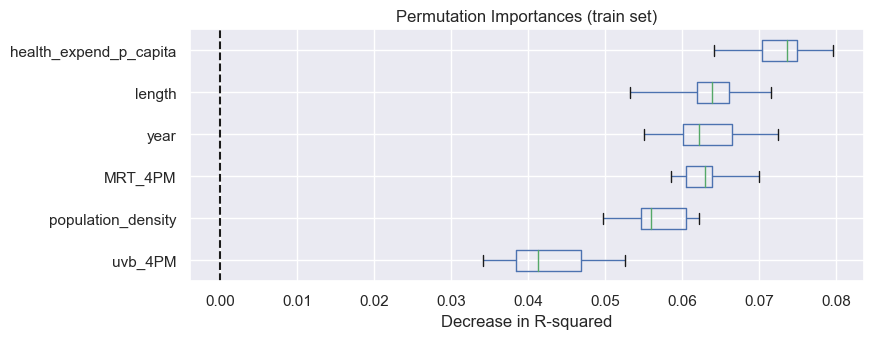

In [581]:
# plot feature importance
sns.set(rc={'figure.figsize':(8.7,3.27)})
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in R-squared")
#ax.figure.tight_layout()

In [76]:
# deadliest heat wave
X_test.loc[[378]]

country_is_AL  country_is_AT  country_is_BE  country_is_BG  \
378              0              0              0              0   

     country_is_CH  country_is_CZ  country_is_DK  country_is_EE  \
378              0              0              0              0   

     country_is_EL  country_is_ES  country_is_FI  country_is_FR  \
378              0              1              0              0   

     country_is_HU  country_is_IT  country_is_LT  country_is_LU  \
378              0              0              0              0   

     country_is_LV  country_is_ME  country_is_NL  country_is_NO  \
378              0              0              0              0   

     country_is_PL  country_is_PT  country_is_RO  country_is_RS  \
378              0              0              0              0   

     country_is_SE  country_is_SK  region_is_AT1  region_is_AT2  \
378              0              0              0              0   

     region_is_AT3  region_is_BE2  region_is_BE3  region_is_BG3  \
378              0              0              0              0   

     region_is_BG4  region_is_EL4  region_is_EL5  region_is_EL6  \
378              0              0              0              0   

     region_is_ES1  region_is_ES2  region_is_ES3  region_is_ES4  \
378              0              0              0              0   

     region_is_ES5  region_is_ES6  region_is_FI1  region_is_FI2  \
378              0              1              0              0   

     region_is_FR1  region_is_FRB  region_is_FRC  region_is_FRD  \
378              0              0              0              0   

     region_is_FRE  region_is_FRF  region_is_FRG  region_is_FRH  \
378              0              0              0              0   

     region_is_FRI  region_is_FRJ  region_is_FRK  region_is_FRL  \
378              0              0              0              0   

     region_is_FRM  region_is_HU1  region_is_HU2  region_is_HU3  \
378              0              0              0              0   

     region_is_ITC  region_is_ITF  region_is_ITG  region_is_ITH  \
378              0              0              0              0   

     region_is_ITI  region_is_NL1  region_is_NL2  region_is_NL3  \
378              0              0              0              0   

     region_is_NL4  region_is_PL2  region_is_PL4  region_is_PL5  \
378              0              0              0              0   

     region_is_PL6  region_is_PL7  region_is_PL8  region_is_PL9  \
378              0              0              0              0   

     region_is_PT1  region_is_RO1  region_is_RO2  region_is_RO3  \
378              0              0              0              0   

     region_is_RO4  region_is_RS1  region_is_RS2  region_is_SE1  \
378              0              0              0              0   

     region_is_SE2  region_is_SE3  latitude  longitude  \
378              0              0     37.75      -6.25   

     min_apparent_temperature  min_apparent_temperature_vs_avg  \
378                 27.858333                           1.4972   

     max_apparent_temperature  max_apparent_temperature_vs_avg        uvb_4PM  \
378                 38.898333                         1.311823  268780.268333   

     uvb_4PM_vs_avg  wind_day  wind_day_vs_avg  dew_point_day  \
378        1.088665  1.732083         1.068391       14.97625   

     dew_point_day_vs_avg    MRT_2AM  MRT_2AM_vs_avg    MRT_4PM  \
378              1.357835  18.928333        1.690502  44.288333   

     MRT_4PM_vs_avg  month  year  length  health_expend_p_capita  \
378        1.182828    8.0  2003       6                 1438.22   

     Chronic_lower_respiratory_diseases  Coronary_heart_disease  Diabetes  \
378                                 3.0                    0.75      7.15   

     High_blood_pressure  Obesity  share_over_64  population_density  
378                 19.0     16.1       14.66481                86.1

In [77]:
# 2nd deadliest
X_test.loc[[17]]

country_is_AL  country_is_AT  country_is_BE  country_is_BG  country_is_CH  \
17              0              0              1              0              0   

    country_is_CZ  country_is_DK  country_is_EE  country_is_EL  country_is_ES  \
17              0              0              0              0              0   

    country_is_FI  country_is_FR  country_is_HU  country_is_IT  country_is_LT  \
17              0              0              0              0              0   

    country_is_LU  country_is_LV  country_is_ME  country_is_NL  country_is_NO  \
17              0              0              0              0              0   

    country_is_PL  country_is_PT  country_is_RO  country_is_RS  country_is_SE  \
17              0              0              0              0              0   

    country_is_SK  region_is_AT1  region_is_AT2  region_is_AT3  region_is_BE2  \
17              0              0              0              0              0   

    region_is_BE3  region_is_BG3  region_is_BG4  region_is_EL4  region_is_EL5  \
17              1              0              0              0              0   

    region_is_EL6  region_is_ES1  region_is_ES2  region_is_ES3  region_is_ES4  \
17              0              0              0              0              0   

    region_is_ES5  region_is_ES6  region_is_FI1  region_is_FI2  region_is_FR1  \
17              0              0              0              0              0   

    region_is_FRB  region_is_FRC  region_is_FRD  region_is_FRE  region_is_FRF  \
17              0              0              0              0              0   

    region_is_FRG  region_is_FRH  region_is_FRI  region_is_FRJ  region_is_FRK  \
17              0              0              0              0              0   

    region_is_FRL  region_is_FRM  region_is_HU1  region_is_HU2  region_is_HU3  \
17              0              0              0              0              0   

    region_is_ITC  region_is_ITF  region_is_ITG  region_is_ITH  region_is_ITI  \
17              0              0              0              0              0   

    region_is_NL1  region_is_NL2  region_is_NL3  region_is_NL4  region_is_PL2  \
17              0              0              0              0              0   

    region_is_PL4  region_is_PL5  region_is_PL6  region_is_PL7  region_is_PL8  \
17              0              0              0              0              0   

    region_is_PL9  region_is_PT1  region_is_RO1  region_is_RO2  region_is_RO3  \
17              0              0              0              0              0   

    region_is_RO4  region_is_RS1  region_is_RS2  region_is_SE1  region_is_SE2  \
17              0              0              0              0              0   

    region_is_SE3  latitude  longitude  min_apparent_temperature  \
17              0      50.5       4.25                     21.47   

    min_apparent_temperature_vs_avg  max_apparent_temperature  \
17                         1.924279                    32.995   

    max_apparent_temperature_vs_avg     uvb_4PM  uvb_4PM_vs_avg  wind_day  \
17                          1.68567  182005.515        1.435589  1.328333   

    wind_day_vs_avg  dew_point_day  dew_point_day_vs_avg  MRT_2AM  \
17         0.568592      15.420833               1.35299   15.025   

    MRT_2AM_vs_avg    MRT_4PM  MRT_4PM_vs_avg  month  year  length  \
17        2.144129  37.381667        1.376573    8.0  2020       6   

    health_expend_p_capita  Chronic_lower_respiratory_diseases  \
17             4536.898582                                 4.0   

    Coronary_heart_disease  Diabetes  High_blood_pressure  Obesity  \
17                     1.5      5.55                16.95     15.0   

    share_over_64  population_density  
17      18.857805               354.8

In [78]:
y_test_df = pd.DataFrame(y_test, columns=['death_p_100k_vs_avg']).sort_values(by=['death_p_100k_vs_avg'], ascending=False).head(3)
y_test_df

death_p_100k_vs_avg
378             1.363802
17              1.363168
459             1.349376

In [69]:
# Calculate Shap values for deadliest
explainer = shap.TreeExplainer(regr)
choosen_instance = X_test.loc[[378]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [70]:
# Calculate Shap values for 2nd deadliest
explainer = shap.TreeExplainer(regr)
choosen_instance = X_test.loc[[17]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [85]:
# find least deadly heat wave
y_test_df = pd.DataFrame(y_test, columns=['death_p_100k_vs_avg']).sort_values(by=['death_p_100k_vs_avg'], ascending=False).tail(1)
y_test_df

death_p_100k_vs_avg
327             0.816298

In [86]:
# show least deadly heat wave
X_test.loc[[327]]

country_is_AL  country_is_AT  country_is_BE  country_is_BG  \
327              0              0              0              0   

     country_is_CH  country_is_CZ  country_is_DK  country_is_EE  \
327              0              0              0              0   

     country_is_EL  country_is_ES  country_is_FI  country_is_FR  \
327              0              0              0              0   

     country_is_HU  country_is_IT  country_is_LT  country_is_LU  \
327              0              0              0              0   

     country_is_LV  country_is_ME  country_is_NL  country_is_NO  \
327              0              0              0              0   

     country_is_PL  country_is_PT  country_is_RO  country_is_RS  \
327              0              0              0              0   

     country_is_SE  country_is_SK  region_is_AT1  region_is_AT2  \
327              1              0              0              0   

     region_is_AT3  region_is_BE2  region_is_BE3  region_is_BG3  \
327              0              0              0              0   

     region_is_BG4  region_is_EL4  region_is_EL5  region_is_EL6  \
327              0              0              0              0   

     region_is_ES1  region_is_ES2  region_is_ES3  region_is_ES4  \
327              0              0              0              0   

     region_is_ES5  region_is_ES6  region_is_FI1  region_is_FI2  \
327              0              0              0              0   

     region_is_FR1  region_is_FRB  region_is_FRC  region_is_FRD  \
327              0              0              0              0   

     region_is_FRE  region_is_FRF  region_is_FRG  region_is_FRH  \
327              0              0              0              0   

     region_is_FRI  region_is_FRJ  region_is_FRK  region_is_FRL  \
327              0              0              0              0   

     region_is_FRM  region_is_HU1  region_is_HU2  region_is_HU3  \
327              0              0              0              0   

     region_is_ITC  region_is_ITF  region_is_ITG  region_is_ITH  \
327              0              0              0              0   

     region_is_ITI  region_is_NL1  region_is_NL2  region_is_NL3  \
327              0              0              0              0   

     region_is_NL4  region_is_PL2  region_is_PL4  region_is_PL5  \
327              0              0              0              0   

     region_is_PL6  region_is_PL7  region_is_PL8  region_is_PL9  \
327              0              0              0              0   

     region_is_PT1  region_is_RO1  region_is_RO2  region_is_RO3  \
327              0              0              0              0   

     region_is_RO4  region_is_RS1  region_is_RS2  region_is_SE1  \
327              0              0              0              0   

     region_is_SE2  region_is_SE3  latitude  longitude  \
327              0              1     61.75       14.0   

     min_apparent_temperature  min_apparent_temperature_vs_avg  \
327                   11.8425                         3.258815   

     max_apparent_temperature  max_apparent_temperature_vs_avg     uvb_4PM  \
327                     25.71                         2.049967  139908.755   

     uvb_4PM_vs_avg  wind_day  wind_day_vs_avg  dew_point_day  \
327        1.504372   0.74375          0.42918           11.2   

     dew_point_day_vs_avg  MRT_2AM  MRT_2AM_vs_avg  MRT_4PM  MRT_4PM_vs_avg  \
327              2.086826   7.2825        4.015865    27.43        1.568385   

     month  year  length  health_expend_p_capita  \
327    7.0  2008       4             4274.230273   

     Chronic_lower_respiratory_diseases  Coronary_heart_disease  Diabetes  \
327                                1.55                     1.4      5.55   

     High_blood_pressure  Obesity  share_over_64  population_density  
327                 17.2    14.35      20.035136                 2.6

In [72]:
# Calculate Shap values for least deadly heat wave
explainer = shap.TreeExplainer(regr)
choosen_instance = X_test.loc[[327]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

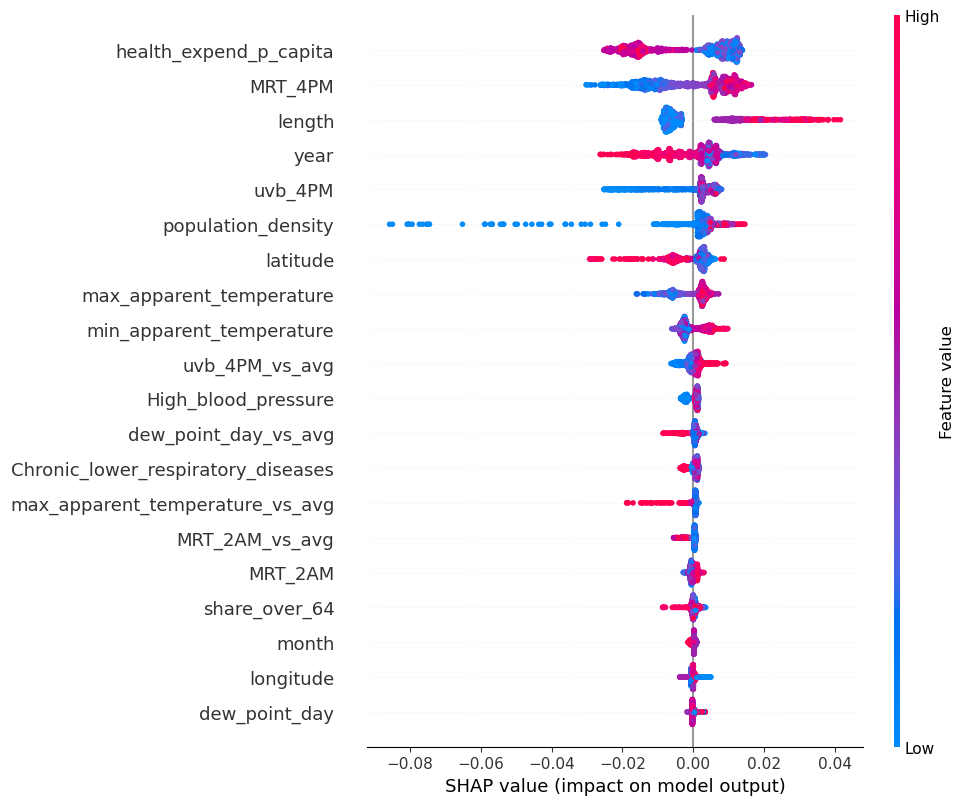

In [501]:
# plot global Shapley values
shap.initjs()

explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

## Plot training and cv error versus increasing sample size

In [62]:
train_sizes=[100, 300, 500, 700, 900, 1100, 1300]

In [68]:
estimator = RandomForestRegressor()
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X_train,
        y_train,
        cv=5,
        train_sizes=train_sizes,
        return_times=True,
    )

In [69]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [70]:
test_scores_mean

array([0.05193819, 0.24733915, 0.31054054, 0.33645924, 0.36135234,
       0.38965572, 0.42084867])

Text(0, 0.5, 'R squared')

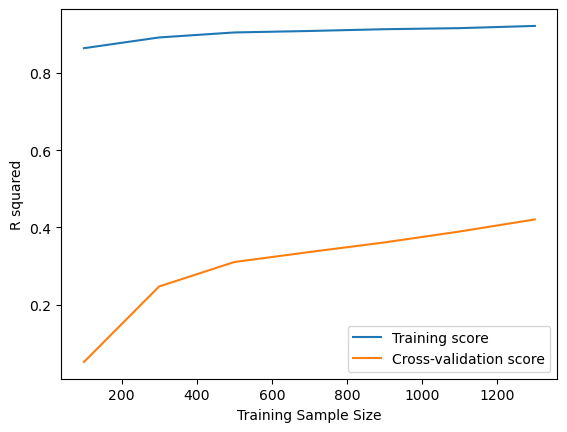

In [77]:
sns.reset_defaults()
df = pd.DataFrame({
   'Training score': train_scores_mean,
   'Cross-validation score': test_scores_mean
   }, index=[100, 300, 500, 700, 900, 1100, 1300])
lines = df.plot.line()#x='Sample Size', y='R squared')
lines.set_xlabel("Training Sample Size")
lines.set_ylabel("R squared")

# Illustartion of Isolation Forest

In [105]:
# initialize list of lists
data = [[6, 6], [14,14], [14.3,14.2],[13.7,13.8], [14.5,14.6], [14.2,14.3], [13.8,14.35], [13.8,13.5], [13.75,14.15], [14.001,14.5], [14.001,13.6]]
  
# # Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['x', 'y'])

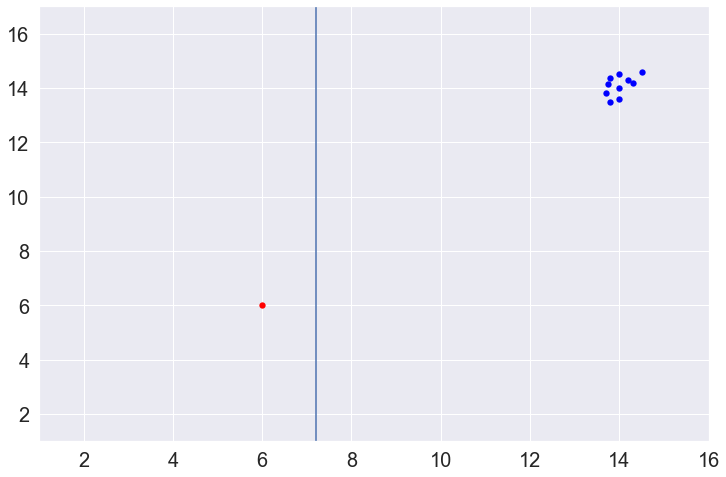

In [106]:
plt.figure(figsize=(12, 8))
col =[]
for i in range(0, len(df['x'])):
    if df['x'][i]==6:
        col.append('red')  
    else:
        col.append('blue') 
  
for i in range(len(df['x'])):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(df['x'][i], df['y'][i], c = col[i], s = 40,
                linewidth = 0)

plt.tick_params(axis='both', which='major', labelsize=20)
# Set x-axis range

plt.xlim(1,16)
    
# Set y-axis range

plt.ylim(1,17)
plt.axvline(x=7.2)
plt.show()

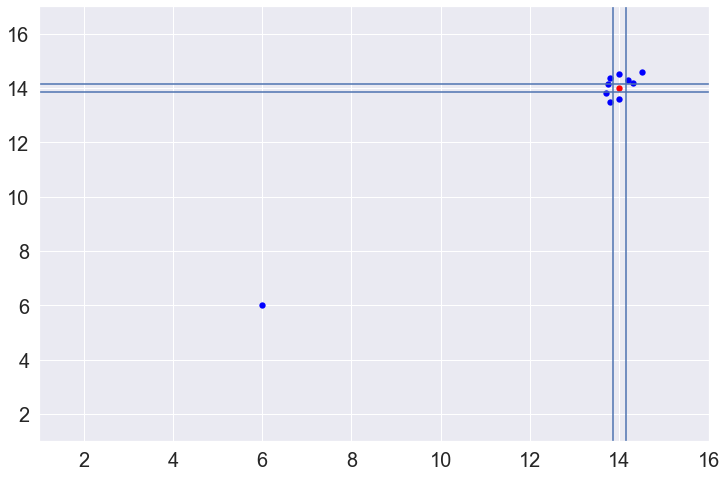

In [107]:
plt.figure(figsize=(12, 8))
col =[]
for i in range(0, len(df['x'])):
    if df['x'][i]==14:
        col.append('red')  
    else:
        col.append('blue') 
  
for i in range(len(df['x'])):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(df['x'][i], df['y'][i], c = col[i], s = 40,
                linewidth = 0)

plt.tick_params(axis='both', which='major', labelsize=20)
# Set x-axis range

plt.xlim(1,16)
    
# Set y-axis range

plt.ylim(1,17)
plt.axvline(x=13.85)
plt.axvline(x=14.15)
plt.axhline(y=14.15)
plt.axhline(y=13.85)
plt.show()

In [78]:
X_train['MRT_4PM'].corr(X_train['max_apparent_temperature'])

0.8022189099740179